## GaussianProcessRegressorのサンプルコード

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_boston
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
# データセットの読込み
boston = load_boston()

# 説明変数の格納
df = pd.DataFrame(boston.data, columns=boston.feature_names)
# 目的変数の追加
df["MEDV"] = boston.target

# データの中身を確認
df.head()

/tmp/Python/python-3.9.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


#### 前処理

In [3]:
# ランダムシード値
RANDOM_STATE = 10

# 学習データと評価データの割合
TEST_SIZE = 0.2

# 学習データと評価データを作成
x_train, x_test, y_train, y_test = train_test_split(
    df.iloc[:, 0 : df.shape[1] - 1],
    df.iloc[:, df.shape[1] - 1],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

# データを標準化
sc_x = StandardScaler()
sc_x.fit(x_train)
x_train_std = sc_x.transform(x_train)
x_test_std = sc_x.transform(x_test)

sc_y = StandardScaler()
sc_y.fit(y_train.values.reshape(-1, 1))
y_train_std = sc_y.transform(y_train.values.reshape(-1, 1))
y_test_std = sc_y.transform(y_test.values.reshape(-1, 1))

In [4]:
# カーネル関数の設定
kernel = ConstantKernel() * RBF() + WhiteKernel()

# モデルの作成
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0, random_state=RANDOM_STATE)

# モデルの学習
gpr.fit(x_train_std, y_train_std)

GaussianProcessRegressor(alpha=0,
                         kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         random_state=10)

In [5]:
# kernel関数のパラメータの確認
print(gpr.kernel_)

1.39**2 * RBF(length_scale=3.15) + WhiteKernel(noise_level=0.0659)


In [6]:
# 推論
y_pred, sigma = gpr.predict(x_test_std, return_std=True)

In [7]:
# 標準化を戻す
y_test = sc_y.inverse_transform(y_test_std)
pred_mu = sc_y.inverse_transform(y_pred)
pred_sigma = sigma.reshape(-1, 1) * sc_y.scale_

# リストにまとめる
result = list(zip(y_test.reshape(-1), pred_mu.reshape(-1), pred_sigma.reshape(-1)))

# データフレームへ
df_result = pd.DataFrame(result, columns=["obs", "pred_mu", "pred_sigma"])

In [8]:
def make_yyplot(df_result, xy_min=0, xy_max=60):
    x = np.arange(xy_min, xy_max)
    y = x

    # Observed-Predicted Plot(yyplot) の作成
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)

    ax.plot(x, y)
    ax.errorbar(
        df_result["obs"], df_result["pred_mu"], yerr=df_result["pred_sigma"], fmt="o"
    )

    ax.set_xlim(xy_min, xy_max)
    ax.set_ylim(xy_min, xy_max)

    ax.set_xlabel("y_observed")
    ax.set_ylabel("y_predicted")

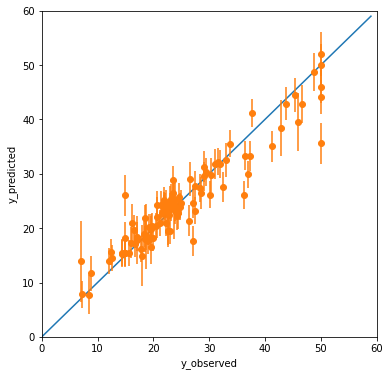

In [9]:
make_yyplot(df_result)

In [10]:
def calculate_scores(true, pred):
    """全ての評価指標を計算する

    Parameters
    ----------
    true (np.array)       : 実測値
    pred (np.array)       : 予測値

    Returns
    -------
    scores (pd.DataFrame) : 各評価指標を纏めた結果

    """
    scores = {}
    scores = pd.DataFrame(
        {
            "R2": r2_score(true, pred),
            "MAE": mean_absolute_error(true, pred),
            "MSE": mean_squared_error(true, pred),
            "RMSE": np.sqrt(mean_squared_error(true, pred)),
        },
        index=["scores"],
    )
    return scores

In [11]:
scores = calculate_scores(df_result["obs"], df_result["pred_mu"])
print(scores)

              R2       MAE       MSE      RMSE
scores  0.887457  2.363148  11.76978  3.430711
